# PyBaMM Demo

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/"
res_DIR = "../data/results/"


# Set Parameters and Expansion Functions

In [2]:

parameter_values = get_parameter_values()

## Search Parameters

# Set Cell No

## Read Cell data

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

# Set PyBaMM experiment

In [4]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

## Set Additional Parameters

In [5]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


# Simulate

In [6]:
sim_0 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_0 = sim_0.solve(initial_soc=1)

parameter_values.update(
    {
        "Initial temperature [K]": 273.15+45,
        "Ambient temperature [K]": 273.15+45,

    },
    check_already_exists=False,
)
sim_1 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_1 = sim_1.solve(initial_soc=1)

parameter_values.update(
    {
        "Initial temperature [K]": 273.15-5,
        "Ambient temperature [K]": 273.15-5,

    },
    check_already_exists=False,
)
sim_2 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_2 = sim_2.solve(initial_soc=1)

# Define plotting variables

In [7]:
spm.variables.search("concentration")

Average negative particle concentration
Average negative particle concentration [mol.m-3]
Average positive particle concentration
Average positive particle concentration [mol.m-3]
Dead lithium concentration
Dead lithium concentration [mol.m-3]
EC surface concentration
EC surface concentration [mol.m-3]
Electrolyte concentration
Electrolyte concentration [Molar]
Electrolyte concentration [mol.m-3]
Inner SEI concentration [mol.m-3]
Inner SEI on cracks concentration [mol.m-3]
Lithium plating concentration
Lithium plating concentration [mol.m-3]
Maximum negative particle concentration
Maximum negative particle concentration [mol.m-3]
Maximum negative particle surface concentration
Maximum negative particle surface concentration [mol.m-3]
Maximum positive particle concentration
Maximum positive particle concentration [mol.m-3]
Maximum positive particle surface concentration
Maximum positive particle surface concentration [mol.m-3]
Minimum negative particle concentration
Minimum negative par

In [8]:
t =  sol_0["Time [s]"].entries
I =  sol_0["Current [A]"].entries
Q = -sol_0['Discharge capacity [A.h]'].entries
V =  sol_0["Terminal voltage [V]"].entries

sigma_ts_n = sol_0["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n = sol_0["X-averaged negative particle surface radial stress [Pa]"].entries
cs_sur_n =   sol_0["X-averaged negative particle surface concentration"].entries
cs_sur_p =   sol_0["X-averaged positive particle surface concentration"].entries
cs_ave_n =   sol_0["Negative electrode volume-averaged concentration"].entries
cs_ave_p =   sol_0["Positive electrode volume-averaged concentration"].entries
sigma_hs_n = (sigma_rs_n + 2 * sigma_ts_n) / 3

In [9]:
t_1 =  sol_1["Time [s]"].entries
I_1 =  sol_1["Current [A]"].entries
Q_1 = -sol_1['Discharge capacity [A.h]'].entries
V_1 =  sol_1["Terminal voltage [V]"].entries

sigma_ts_n_1 = sol_1["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n_1 = sol_1["X-averaged negative particle surface radial stress [Pa]"].entries
cs_sur_n_1 =   sol_1["X-averaged negative particle surface concentration"].entries
cs_sur_p_1 =   sol_1["X-averaged positive particle surface concentration"].entries
cs_ave_n_1 =   sol_1["Negative electrode volume-averaged concentration"].entries
cs_ave_p_1 =   sol_1["Positive electrode volume-averaged concentration"].entries
sigma_hs_n_1 = (sigma_rs_n_1 + 2 * sigma_ts_n_1) / 3

In [10]:
t_2 =  sol_2["Time [s]"].entries
I_2 =  sol_2["Current [A]"].entries
Q_2 = -sol_2['Discharge capacity [A.h]'].entries
V_2 =  sol_2["Terminal voltage [V]"].entries

sigma_ts_n_2 = sol_2["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n_2 = sol_2["X-averaged negative particle surface radial stress [Pa]"].entries
cs_sur_n_2 =   sol_2["X-averaged negative particle surface concentration"].entries
cs_sur_p_2 =   sol_2["X-averaged positive particle surface concentration"]
cs_ave_n_2 =   sol_2["Negative electrode volume-averaged concentration"].entries
cs_ave_p_2 =   sol_2["Positive electrode volume-averaged concentration"].entries
sigma_hs_n_2 = (sigma_rs_n_2 + 2 * sigma_ts_n_2) / 3

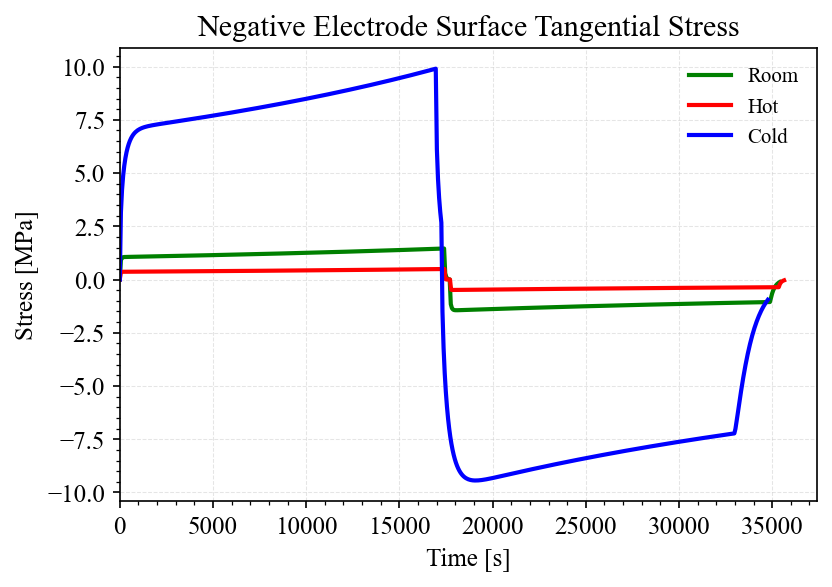

In [11]:
plt.figure()
plt.plot(t,sigma_hs_n/1e6,'g')
plt.plot(t_1,sigma_hs_n_1/1e6,'r')
plt.plot(t_2,sigma_hs_n_2/1e6,'b')
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Stress [MPa]')
plt.title('Negative Electrode Surface Tangential Stress')
plt.legend(['Room','Hot','Cold'])
# plt.savefig(fig_DIR+'compare_temp_stress'+'.png')

Text(0, 0.5, 'Stress [Pa]')

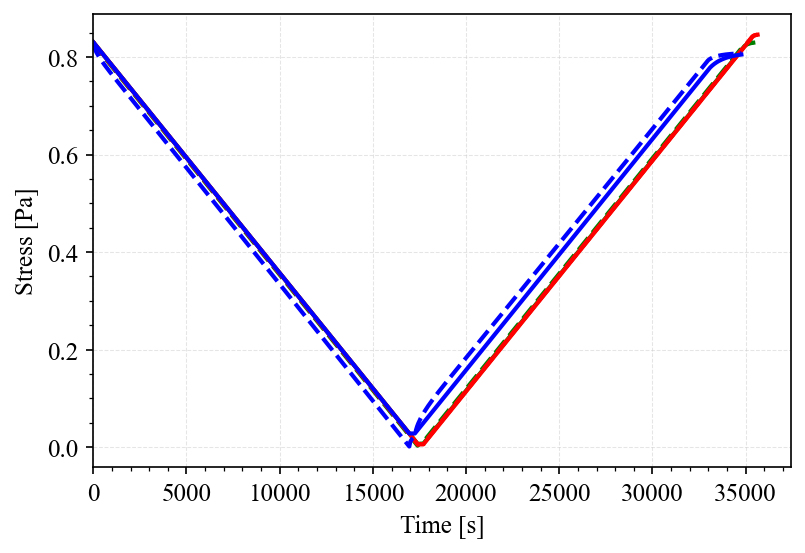

In [12]:
plt.figure()
plt.plot(t,cs_sur_n,'g--',t,cs_ave_n,'g')
plt.plot(t_1,cs_sur_n_1,'r--',t_1,cs_ave_n_1,'r')
plt.plot(t_2,cs_sur_n_2,'b--',t_2,cs_ave_n_2,'b')
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Stress [Pa]')
# plt.title('Negative Electrode Surface Tangential Stress')
# plt.legend(['Room','Hot','Cold'])
# plt.savefig(fig_DIR+'compare_prot_lipc'+'.png')

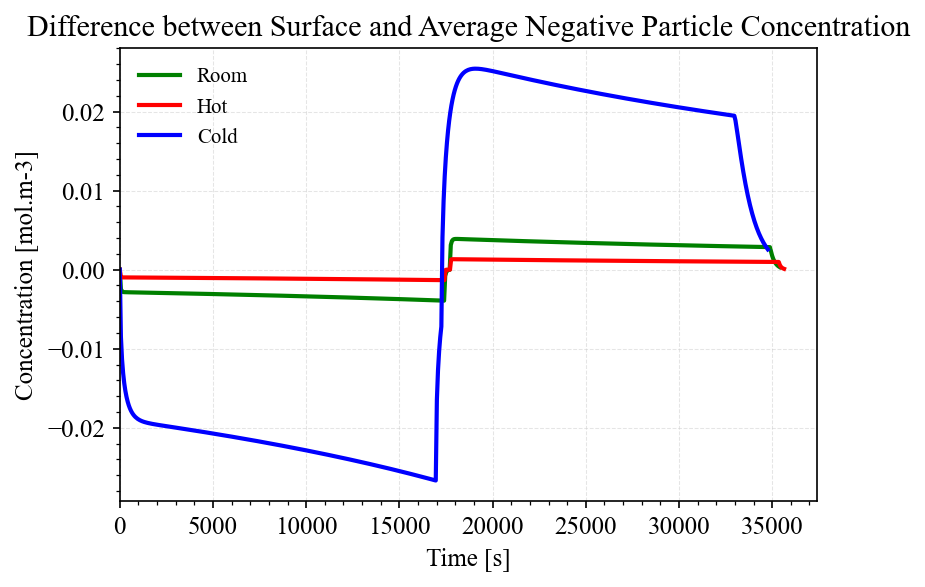

In [13]:
plt.figure()
plt.plot(t,cs_sur_n-cs_ave_n,'g')
plt.plot(t_1,cs_sur_n_1-cs_ave_n_1,'r')
plt.plot(t_2,cs_sur_n_2-cs_ave_n_2,'b')
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Concentration [mol.m-3]')
plt.title('Difference between Surface and Average Negative Particle Concentration')
plt.legend(['Room','Hot','Cold'])
# plt.savefig(fig_DIR+'compare_temp_conc_diff'+'.png')

In [14]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [15]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [16]:
sim_3 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_3 = sim_3.solve(initial_soc=1)

parameter_values.update(
    {
        "Initial temperature [K]": 273.15+45,
        "Ambient temperature [K]": 273.15+45,

    },
    check_already_exists=False,
)
sim_4 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_4 = sim_4.solve(initial_soc=1)

parameter_values.update(
    {
        "Initial temperature [K]": 273.15-5,
        "Ambient temperature [K]": 273.15-5,

    },
    check_already_exists=False,
)
sim_5 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_5 = sim_5.solve(initial_soc=1)

In [17]:
t_3 =  sol_3["Time [s]"].entries
I_3 =  sol_3["Current [A]"].entries
Q_3 = -sol_3['Discharge capacity [A.h]'].entries
V_3 =  sol_3["Terminal voltage [V]"].entries

sigma_ts_n_3 = sol_3["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n_3 = sol_3["X-averaged negative particle surface radial stress [Pa]"].entries
cs_sur_n_3 =   sol_3["X-averaged negative particle surface concentration"].entries
cs_sur_p_3 =   sol_3["X-averaged positive particle surface concentration"].entries
cs_ave_n_3 =   sol_3["Negative electrode volume-averaged concentration"].entries
cs_ave_p_3 =   sol_3["Positive electrode volume-averaged concentration"].entries
sigma_hs_n_3 = (sigma_rs_n_3 + 2 * sigma_ts_n_3) / 3

t_4 =  sol_4["Time [s]"].entries
I_4 =  sol_4["Current [A]"].entries
Q_4 = -sol_4['Discharge capacity [A.h]'].entries
V_4 =  sol_4["Terminal voltage [V]"].entries

sigma_ts_n_4 = sol_4["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n_4 = sol_4["X-averaged negative particle surface radial stress [Pa]"].entries
cs_sur_n_4 =   sol_4["X-averaged negative particle surface concentration"].entries
cs_sur_p_4 =   sol_4["X-averaged positive particle surface concentration"].entries
cs_ave_n_4 =   sol_4["Negative electrode volume-averaged concentration"].entries
cs_ave_p_4 =   sol_4["Positive electrode volume-averaged concentration"].entries
sigma_hs_n_4 = (sigma_rs_n_4 + 2 * sigma_ts_n_4) / 3

t_5 =  sol_5["Time [s]"].entries
I_5 =  sol_5["Current [A]"].entries
Q_5 = -sol_5['Discharge capacity [A.h]'].entries
V_5 =  sol_5["Terminal voltage [V]"].entries

sigma_ts_n_5 = sol_5["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n_5 = sol_5["X-averaged negative particle surface radial stress [Pa]"].entries
cs_sur_n_5 =   sol_5["X-averaged negative particle surface concentration"].entries
cs_sur_p_5 =   sol_5["X-averaged positive particle surface concentration"].entries
cs_ave_n_5 =   sol_5["Negative electrode volume-averaged concentration"].entries
cs_ave_p_5 =   sol_5["Positive electrode volume-averaged concentration"].entries
sigma_hs_n_5 = (sigma_rs_n_5 + 2 * sigma_ts_n_5) / 3

In [18]:
sigma_list = [sigma_hs_n/1e6, sigma_hs_n_1/1e6, sigma_hs_n_2/1e6, sigma_hs_n_3/1e6, sigma_hs_n_4/1e6, sigma_hs_n_5/1e6]
for sss in sigma_list:
    print(round(max(sss),2))

1.46
0.49
9.9
11.0
3.76
69.49


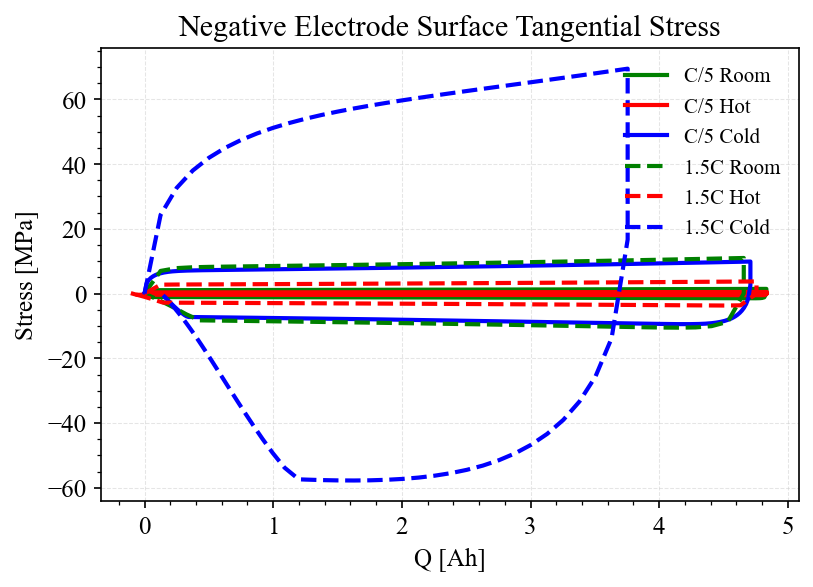

In [19]:
plt.figure()
plt.plot(-Q,sigma_hs_n/1e6,'g')
plt.plot(-Q_1,sigma_hs_n_1/1e6,'r')
plt.plot(-Q_2,sigma_hs_n_2/1e6,'b')
plt.plot(-Q_3,sigma_hs_n_3/1e6,'g--')
plt.plot(-Q_4,sigma_hs_n_4/1e6,'r--')
plt.plot(-Q_5,sigma_hs_n_5/1e6,'b--')
# plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Stress [MPa]')
plt.title('Negative Electrode Surface Tangential Stress')
plt.legend(['C/5 Room','C/5 Hot','C/5 Cold','1.5C Room','1.5C Hot','1.5C Cold'])
plt.savefig(fig_DIR+'compare_temp_stress'+'.png')

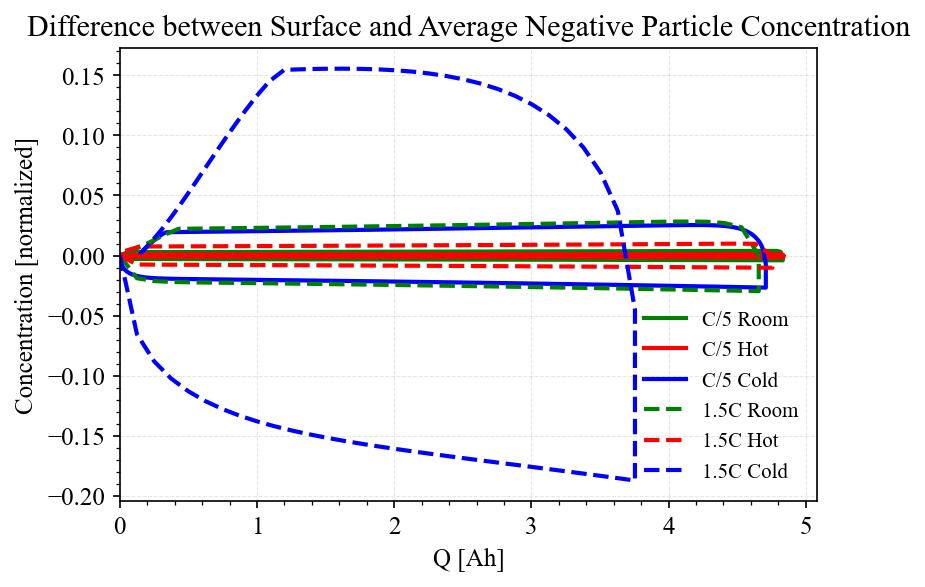

In [20]:
plt.figure()
plt.plot(-Q,cs_sur_n-cs_ave_n,'g')
plt.plot(-Q_1,cs_sur_n_1-cs_ave_n_1,'r')
plt.plot(-Q_2,cs_sur_n_2-cs_ave_n_2,'b')
plt.plot(-Q_3,cs_sur_n_3-cs_ave_n_3,'g--')
plt.plot(-Q_4,cs_sur_n_4-cs_ave_n_4,'r--')
plt.plot(-Q_5,cs_sur_n_5-cs_ave_n_5,'b--')
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Concentration [normalized]')
plt.title('Difference between Surface and Average Negative Particle Concentration')
plt.legend(['C/5 Room','C/5 Hot','C/5 Cold','1.5C Room','1.5C Hot','1.5C Cold'])
plt.savefig(fig_DIR+'compare_temp_conc_diff'+'.png')